In [2]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

In [38]:
# Define matrix size
n = 10
# Create a random matrix A
A = np.random.rand(n, n)
A_trans = A * 2 - 1

# Create a symmetric positive definite matrix using A^T * A
M = np.dot(A_trans.T, A_trans)

# Normalize the diagonal to be ones
diagonal = np.sqrt(np.diag(M))
M_normalised = M / diagonal[:, None] / diagonal[None, :]

# Check eigenvalues to confirm positive definiteness
eigenvalues = np.linalg.eigvals(M_normalised)
print(eigenvalues)
M_normalised

[2.73188581e+00 1.92050504e+00 1.65968469e+00 1.19217020e+00
 1.05009561e+00 6.00777090e-01 5.54723386e-01 1.04962723e-03
 9.74646725e-02 1.91643876e-01]


array([[ 1.        ,  0.13783071,  0.20098282, -0.08420337, -0.18148619,
        -0.11929313, -0.1534413 ,  0.26587557,  0.06445959,  0.08526583],
       [ 0.13783071,  1.        ,  0.48291846,  0.13314615, -0.0065375 ,
        -0.28710568, -0.03930065,  0.17562059, -0.14179085, -0.34156368],
       [ 0.20098282,  0.48291846,  1.        ,  0.43964309, -0.1348051 ,
         0.27318148,  0.08008407,  0.48123044,  0.03784432, -0.08803236],
       [-0.08420337,  0.13314615,  0.43964309,  1.        , -0.26468299,
         0.29552708,  0.3778606 , -0.23444715,  0.63037527, -0.672932  ],
       [-0.18148619, -0.0065375 , -0.1348051 , -0.26468299,  1.        ,
        -0.52865741, -0.06300948,  0.19051035, -0.25164284, -0.05441515],
       [-0.11929313, -0.28710568,  0.27318148,  0.29552708, -0.52865741,
         1.        ,  0.20983852,  0.08986042,  0.10006554,  0.00310124],
       [-0.1534413 , -0.03930065,  0.08008407,  0.3778606 , -0.06300948,
         0.20983852,  1.        ,  0.12029931

In [39]:
# Generate n - 1 random numbers between 0 and 1
random_numbers = np.random.rand(n - 1)

# Append 0 at the start and 1 at the end to define the range of the entire interval
random_numbers = np.append(random_numbers, [1])
random_numbers = np.insert(random_numbers, 0, [0])

# Sort the random numbers to ensure the differences between them sum up to 1
random_numbers.sort()

# Calculate the differences between consecutive numbers to get n numbers that sum up to 1
alpha = np.diff(random_numbers)

sum(alpha)
print(alpha)

[0.10671661 0.1088478  0.02510483 0.10153076 0.29788723 0.00671298
 0.0080702  0.29624998 0.01030856 0.03857102]


In [40]:
import numpy as np
from scipy.stats import t
from scipy.stats import norm
import matplotlib.pyplot as plt

v = 5
R = M_normalised

A = np.linalg.cholesky(R)

Z = np.random.normal(size=(10000, n)).T

s = np.random.chisquare(v, (10000, n)).T

y = A.dot(Z)

x = np.sqrt(v) * y / np.sqrt(s)

# Assuming you want to calculate the CDF of x under a t-distribution for each component

u = t.cdf(x, df=v)

u.shape

(10, 10000)

In [41]:
rng = np.random.default_rng(68)
N = n
h = 10**-4
t = np.arange(0,1.00,h)
Z = (rng.standard_normal(size=(len(t),N))).T
# Cholesky decomposition
A = np.linalg.cholesky(M_normalised)
# Create correlated normal random variables
W = norm.ppf(u)
a = 0
sig = 1
X = 5*np.ones((N, len(t)))
for i in range(len(t)):
    
    for asset in range(N):
           X[asset, i] = X[asset, i-1] + h * a * (np.mean(X[:, i-1]) - X[asset, i-1]) + sig * np.sqrt(h) * W[asset, i-1]


In [60]:
epsilon = 4
d = 0.02#np.random.uniform(0.01, 0.1, 1)

# Initialize a vector to track if the reduction has been applied for each asset
reduction_applied = np.full(n, False)
# Initialize a mask to track active assets for mean calculation
active_assets = np.full(n, True)

# Set the initial values for all assets to 5 at t[0]
X[:, 0] = 5

for i in range(1, len(t)):
    reduction_needed = False
    for asset in range(N):
        if X[asset, i-1] != 0:
            # Calculate the mean over active assets only
            active_mean = sum((X[active_assets, i-1])/len(active_assets))
            # Update using the active mean
            X[asset, i] = X[asset, i-1] + h * a * (active_mean - X[asset, i-1]) + sig * np.sqrt(h) * W[asset, i-1]
        
        if X[asset, i] <= epsilon and not reduction_applied[asset]:
            X[asset, i:-1] = 0
            reduction_needed = True
            reduction_applied[asset] = True
            # Exclude the asset from the active mask for mean calculation
            active_assets[asset] = False

    if reduction_needed:
        for other_asset in range(N):
            if not reduction_applied[other_asset]:
                X[other_asset, i] = X[other_asset, i] * (1 - d)

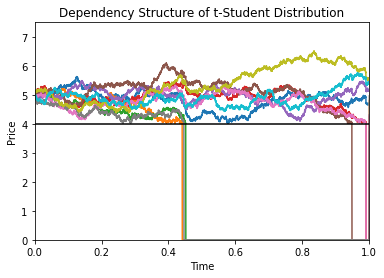

In [61]:
for i in range(N):
    plt.plot(t, X[i, :])  
plt.axhline(y=epsilon, color='k', linestyle='-')
plt.xlim(0, 1)
plt.ylim(0, 7.5)
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Dependency Structure of t-Student Distribution')
plt.show()  

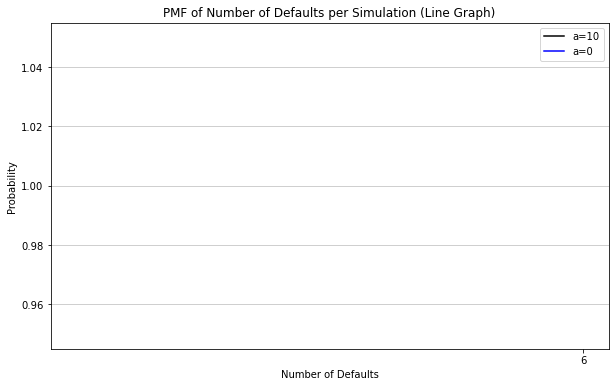

In [32]:
import numpy as np
import matplotlib.pyplot as plt

def count_defaults(asset_prices, threshold):

    # Check if prices fall below the threshold
    below_threshold = asset_prices < threshold
    # Count the number of assets that fall below the threshold at any time
    defaults = np.sum(np.any(below_threshold, axis=1))
    return defaults

# Example usage within a Monte Carlo simulation context
n_simulations = 10  # Number of simulations
n_assets = n  # Number of assets
threshold = 4.3  # Default threshold
h = 10**-4  # Step size
W = norm.ppf(u)
t = np.arange(0, 1.00, h)  # Time array
a = 0  # Drift parameter
sig = 1  # Volatility parameter
defaults_per_simulation = np.zeros(n_simulations)

for sim in range(n_simulations):
    rng = np.random.default_rng(sim)
    Z = rng.standard_normal(size=(len(t), n_assets)).T
    X = 5 * np.ones((n_assets, len(t)))
    for i in range(1, len(t)):
        for asset in range(n_assets):
            X[asset, i] = X[asset, i-1] + h * a * (np.mean(X[:, i-1]) - X[asset, i-1]) + sig * np.sqrt(h) * W[asset, i-1]
    defaults = count_defaults(X, threshold)
    defaults_per_simulation[sim] = defaults

# Given: defaults_per_simulation, an array of counts of defaults per simulation

# Calculate the frequencies of each count of defaults
unique_counts, counts_frequencies = np.unique(defaults_per_simulation, return_counts=True)

# Normalize the frequencies to get probabilities (PMF)
probabilities = counts_frequencies / n_simulations

# Example usage within a Monte Carlo simulation context
n_simulations = 10  # Number of simulations
n_assets = 10  # Number of assets
threshold = 4.3  # Default threshold
h = 10**-4  # Step size
t = np.arange(0, 1.00, h)  # Time array
a = 10 # Drift parameter
sig = 1  # Volatility parameter
defaults_per_simulation_10 = np.zeros(n_simulations)

for sim in range(n_simulations):
    rng = np.random.default_rng(sim)
    Z = rng.standard_normal(size=(len(t), n_assets)).T
    X = 5 * np.ones((n_assets, len(t)))
    for i in range(1, len(t)):
        for asset in range(n_assets):
            X[asset, i] = X[asset, i-1] + h * a * (np.mean(X[:, i-1]) - X[asset, i-1]) + sig * np.sqrt(h) * W[asset, i-1]
    defaults = count_defaults(X, threshold)
    defaults_per_simulation_10[sim] = defaults

# Given: defaults_per_simulation, an array of counts of defaults per simulation

# Calculate the frequencies of each count of defaults
unique_counts_10, counts_frequencies_10 = np.unique(defaults_per_simulation_10, return_counts=True)

# Normalize the frequencies to get probabilities (PMF)
probabilities_10 = counts_frequencies_10 / n_simulations
plt.figure(figsize=(10, 6))
plt.plot(unique_counts_10, probabilities_10, color = 'black',label='a=10')
plt.plot(unique_counts, probabilities, color='blue', label='a=0')
plt.xlabel('Number of Defaults')
plt.ylabel('Probability')
plt.title('PMF of Number of Defaults per Simulation (Line Graph)')
plt.xticks(unique_counts)  # Ensure we have a tick for each unique count of defaults
plt.grid(axis='y', alpha=0.75)
plt.legend()
plt.show()


In [16]:
epsilon = 3
d = 0.01#np.random.uniform(0.01, 0.1, 1)

# Initialize a vector to track if the reduction has been applied for each asset
reduction_applied = np.full(N, False)
# Initialize a mask to track active assets for mean calculation
active_assets = np.full(N, True)

# Set the initial values for all assets to 5 at t[0]
X[:, 0] = 5

for i in range(1, len(t)):
    reduction_needed = False
    for asset in range(N):
        if X[asset, i-1] != 0:
            # Calculate the mean over active assets only
            active_mean = sum(alpha[active_assets] * (X[active_assets, i-1]))
            # Update using the active mean
            X[asset, i] = X[asset, i-1] + h * a * (active_mean - X[asset, i-1]) + sig * np.sqrt(h) * W[asset, i-1]
        
        if X[asset, i] <= epsilon and not reduction_applied[asset]:
            X[asset, i] = 0
            reduction_needed = True
            reduction_applied[asset] = True
            # Exclude the asset from the active mask for mean calculation
            active_assets[asset] = False

    if reduction_needed:
        for other_asset in range(N):
            if not reduction_applied[other_asset]:
                X[other_asset, i] = X[other_asset, i] * (1 - d)

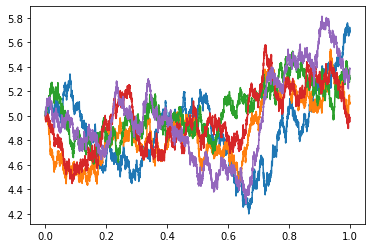

In [17]:
for i in range(N):
    plt.plot(t, X[i, :])  

plt.show()  


In [7]:
from scipy.stats import norm

def phi(x):
    
    return norm.cdf(x, loc=0, scale=1)

T = 1
D = -0.5
p = 2*phi(D/(sig*np.sqrt(T)))

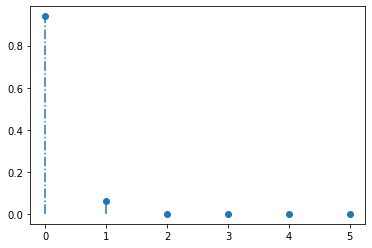

In [8]:
from scipy.stats import binom

# Generate the range of possible outcomes (0 successes to N successes)
x = np.arange(0, N+1)

# Calculate the PMF for each outcome
pmf = binom.pmf(x, N, p)

# Plotting
plt.stem(x, pmf, '-.', basefmt=" ", use_line_collection=True)
plt.xticks(x)  # Ensure every value is marked on the x-axis
plt.show()

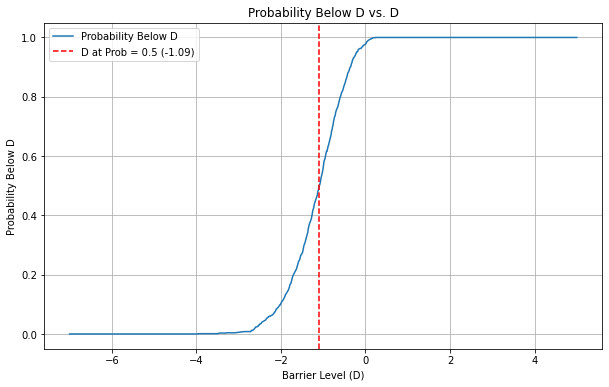

In [112]:
# Parameters
N = n   # Number of paths
T = 1.0     # Total time
M = 100     # Number of time steps
dt = T / M  # Time step size
D_values = np.linspace(-7, 5, 1000)  # Barrier level
probability_below_D = []
rng = np.random.default_rng(68)
h = 0.001
t = np.arange(0,1.00,h)
Z = (rng.standard_normal(size=(len(t),N))).T
# Cholesky decomposition
A = np.linalg.cholesky(M_normalised)
# Create correlated normal random variables
W = A.dot(Z)

for D in D_values:
    # Generate standard normal random numbers for each path and step
    # Assuming each step is independent for simplicity
    
    # Finding the minimum along each path
    min_values = np.min(W, axis=0)
    
    # Checking if minimum values are less than D
    paths_below_D = min_values < D
    probability_below_D.append(np.mean(paths_below_D))
    
prob_array = np.array(probability_below_D)
index_50_percent = (np.abs(prob_array - 0.5)).argmin()
D_50_percent = D_values[index_50_percent]



# Plotting
plt.figure(figsize=(10, 6))
plt.plot(D_values, probability_below_D, label='Probability Below D')
plt.axvline(x=D_50_percent, color='r', linestyle='--', label=f'D at Prob = 0.5 ({D_50_percent:.2f})')

plt.xlabel('Barrier Level (D)')
plt.ylabel('Probability Below D')
plt.title('Probability Below D vs. D')
plt.legend()
plt.grid(True)
plt.show()
#do again and only count below D if at least 50% of trajectories fell below D

## Looks like a sigmoid function around prob D = 0.5

In [64]:
rng = np.random.default_rng()
p = 0.3
N = 10
h = 10**-4
t = np.arange(0,1.00,h)
Z = (rng.standard_normal(size=(len(t),N))).T
W_0 = rng.standard_normal(size = (1,len(t)))
# Cholesky decomposition
A = np.linalg.cholesky(M_normalised)
# Create correlated normal random variables
W = Z#A.dot(Z)
a = 10
sig = 1
X = 5*np.ones((N, len(t)))
for i in range(len(t)):
    
    for asset in range(N):
        X[asset, i] = X[asset, i-1] + h * a * (np.mean(X[:, i-1]) - X[asset, i-1]) + sig * np.sqrt(h) * (p*W_0[0, i-1] + np.sqrt(1 - p**2)*W[asset, i-1])


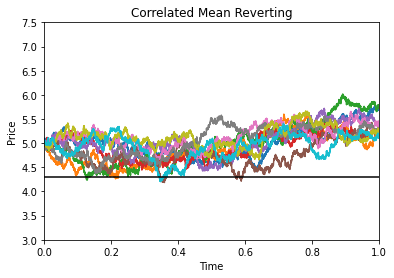

In [65]:
for i in range(N):
    plt.plot(t, X[i, :])  
plt.axhline(y=4.3, color='k', linestyle='-')
plt.xlim(0, 1)
plt.ylim(3, 7.5)
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Correlated Mean Reverting')
plt.show()  